In [1]:
LOAD = False

# reload module each time cell is run
%load_ext autoreload
%autoreload 2

import numpy as np
from numba import njit, jitclass, prange, boolean, int32, double

import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# tools
from tools import linear_interp # for linear interpolation
from tools import misc # various tools
from tools.ConsumptionSavingModel import ConsumptionSavingModel # baseline model classes

# solution and plot routines
import solve_GP2002 as gp
import tools.plot as plot

from tools import SimulatedMinimumDistance as SMD

In [2]:
add_str = '_est'
est_par = ("beta","rho")
est_par_tex = (r'$\hat{\beta}$',r'$\hat{\rho}$')

# choose gamma (fixed)
fixed_par = ('sigma_perm','sigma_trans','p','r','mu_a_init','sigma_a_init')
fixed_par_tex = (r'$\sigma_{n}$',r'$\sigma_{u}$',r'$p$',r'$r$',r'$\tilde{\omega}_{26}$',r'$\sigma_{\omega_{26}}$')

In [3]:
# moment function
@njit
def mom_fun(data):
    return np.log(data.C_avg)

# load data
consumption,income,weight = gp.load_data()
mom_data = np.log(consumption)
theta0 = [0.944, 1.860] 

In [4]:
# Estimate the baseline model
model_base = gp.GP2002()
model_base.draw_random()

smd_base = SMD.SimulatedMinimumDistance(model_base,mom_data,mom_fun,print_iter=False,options={'disp':True})
smd_base.est_par = est_par
if LOAD:
    smd_base.est = theta0
else:
    smd_base.estimate(theta0,weight)

theta_base = smd_base.est

# update model parameters
for p in range(len(est_par)):
    setattr(model_base.par,est_par[p],theta_base[p]) 

# solve and simulate model
model_base.solve() 
model_base.draw_random()
model_base.simulate()

Optimization terminated successfully.
         Current function value: 0.540269
         Iterations: 31
         Function evaluations: 62


beta 0.9441431553959989 rho 1.8603751373128499 
beta 0.9441431553959989 rho 1.8603751373128499 r 0.0344 
beta 0.9441431553959989 rho 1.8603751373128499 r 0.03612 


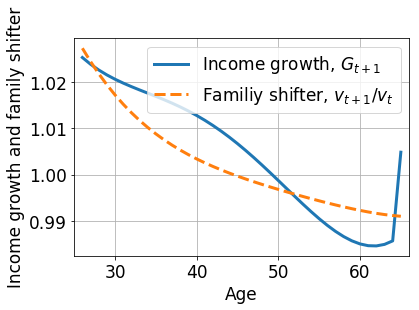

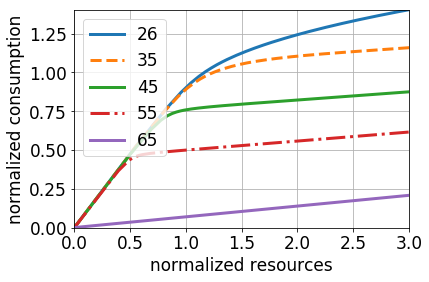

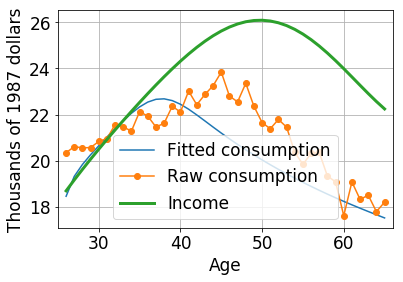

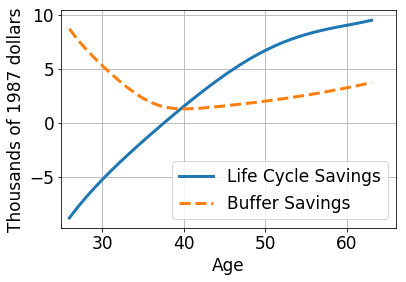

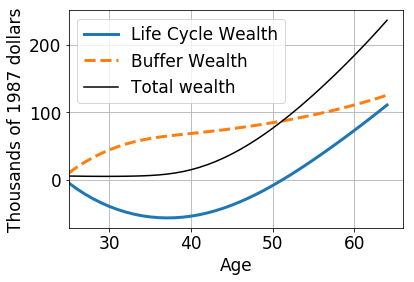

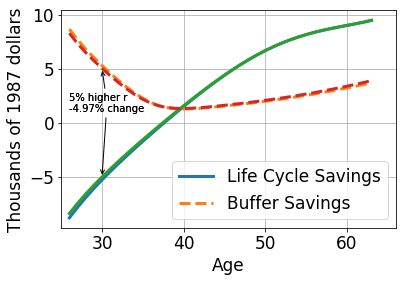

In [5]:
# Construct baseline plots 
plot.cali(model_base)
plot.fig1(model_base,add_str)
plot.fig5(model_base,consumption,income,add_str)
plot.fig7(theta_base,est_par,add_str)

par_vec = np.concatenate((theta_base,[model_base.par.r]),axis=0 )
par_list = (est_par + ('r',))
plot.fig7_higher_r(par_vec,par_list,add_str)

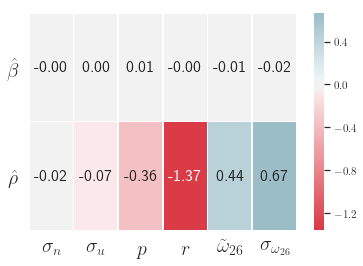

In [8]:
# Construct sensitivity of parameters to calibrated
smd_base.sensitivity(theta_base,weight,fixed_par)
plot.sens_fig_tab(smd_base.sens2,smd_base.sens2e,theta_base,est_par_tex,fixed_par_tex,add_str=add_str)

In [9]:
#######################################################################
# sensitivity of savings-decomposition
print('Sensitivity of savings motives.')
sens = smd_base.sens2
H_base = gp.saving_decomposition_wrap(theta_base,est_par)
num_h = len(H_base)

# gradient wrt theta
print('Caclulating the gradient of savingsmotives wrt. theta')
grad_theta = gp.num_grad(gp.saving_decomposition_wrap,theta_base,num_h,1.0e-5,smd_base.est_par)

# gradient wrt gamma
print('Caclulating the gradient of savingsmotives wrt. gamma')
gamma = np.empty(len(fixed_par))
for p in range(len(fixed_par)):
    gamma[p] = getattr(model_base.par,fixed_par[p])

grad_gamma = gp.num_grad(gp.saving_decomposition_wrap,gamma,num_h,1.0e-5,fixed_par,theta_base,est_par)

# sensitivity measure
sens_H = grad_gamma + grad_theta @ sens

# elasticity
num_gamma = len(gamma)
ela_H = np.empty((num_h,num_gamma))
for g in range(len(gamma)):
    for h in range(num_h):
        ela_H[h,g] = sens_H[h,g]*gamma[g]/H_base[h]


# table with elasticities at age 30 and 60
age = 30
ela_H30 = ela_H[age-27,:]
age = 60
ela_H60 = ela_H[age-27,:]
name = 'output/gp2002_H'  + add_str 
with open(name + '.tex',"w") as file:
    file.write("\\begin{tabular}{l*{%d}{c}} \\toprule \n" %num_gamma)
    for g in range(num_gamma):
        file.write("& %s " %fixed_par_tex[g])
    file.write("\\\\ \\cmidrule(lr){2-%d} \n " %(num_gamma+1))
    file.write("$\hat{H}_{30}^{e}$")
    for g in range(num_gamma):
        file.write("& %2.3f " %ela_H30[g])

    file.write("\\\\ \n $\hat{H}_{60}^{e}$")
    for g in range(num_gamma):
        file.write("& %2.3f " %ela_H60[g])
    file.write("\\\\ \\bottomrule \n \\end{tabular}" )


Sensitivity of savings motives.
beta 0.9441431553959989 rho 1.8603751373128499 
Caclulating the gradient of savingsmotives wrt. theta
beta 0.9441531553959989 rho 1.8603751373128499 
beta 0.944133155395999 rho 1.8603751373128499 
beta 0.9441431553959989 rho 1.860393741064223 
beta 0.9441431553959989 rho 1.8603565335614767 
Caclulating the gradient of savingsmotives wrt. gamma
sigma_perm 0.02121 sigma_trans 0.044 p 0.00302 r 0.0344 mu_a_init 0.06117601977454647 sigma_a_init 1.784 beta 0.9441431553959989 rho 1.8603751373128499 
sigma_perm 0.02119 sigma_trans 0.044 p 0.00302 r 0.0344 mu_a_init 0.06117601977454647 sigma_a_init 1.784 beta 0.9441431553959989 rho 1.8603751373128499 
sigma_perm 0.0212 sigma_trans 0.04401 p 0.00302 r 0.0344 mu_a_init 0.06117601977454647 sigma_a_init 1.784 beta 0.9441431553959989 rho 1.8603751373128499 
sigma_perm 0.0212 sigma_trans 0.043989999999999994 p 0.00302 r 0.0344 mu_a_init 0.06117601977454647 sigma_a_init 1.784 beta 0.9441431553959989 rho 1.8603751373128

In [10]:
# calulate savings decomposition for various risk-free interest rates
pct_grid = [0, 1, 2, 3, 4, 5]
#pct_grid = [0, 1, 2]

noest_H30 = np.empty(len(pct_grid)) 
noest_H60 = np.empty(len(pct_grid))
for i,pct in enumerate(pct_grid):
    model = gp.GP2002()
    model.par.r = model.par.r*(1.0 + pct/100)
    #model.draw_random()

    # update model parameters to baseline estimates and current r
    for p in range(len(est_par)):
        setattr(model.par,est_par[p],theta_base[p]) 

    # calculate savings motives for new values
    upd_par = ("beta","rho","r")
    upd_val = np.empty(len(upd_par))
    for p in range(len(upd_par)):
        upd_val[p] = getattr(model.par,upd_par[p])
       
    (S,S_lc,S_b,W,W_lc,W_b,H) = gp.saving_decomposition(upd_val,upd_par)
    noest_H30[i] = H[30-27]
    noest_H60[i] = H[60-27]
    

beta 0.9441431553959989 rho 1.8603751373128499 r 0.0344 
beta 0.9441431553959989 rho 1.8603751373128499 r 0.034744 
beta 0.9441431553959989 rho 1.8603751373128499 r 0.035088 
beta 0.9441431553959989 rho 1.8603751373128499 r 0.035432 
beta 0.9441431553959989 rho 1.8603751373128499 r 0.035776 
beta 0.9441431553959989 rho 1.8603751373128499 r 0.03612 


# Brute-force estimation of elasticities
Takes some time

In [11]:
brute_est = np.empty((len(est_par),len(fixed_par)))
brute_H = np.empty((2,len(fixed_par)))

for p in range(len(fixed_par)):
    model = gp.GP2002()
    model.draw_random()
    
    # update relevant parameter to 1pct increase
    new_val = getattr(model.par,fixed_par[p]) * (1.01)
    setattr(model.par,fixed_par[p],new_val) 
    print(fixed_par[p],new_val)
    
    # Estimate theta with new calibration
    smd = SMD.SimulatedMinimumDistance(model,mom_data,mom_fun,print_iter=False,options={'disp':True})
    smd.est_par = est_par
    smd.estimate(theta0,weight)
    theta_now = smd.est

    # Update model parameters to estimated values and store them
    for t in range(len(est_par)):
        setattr(model.par,est_par[t],theta_now[t]) 
        brute_est[t,p] = 100.0*(theta_now[t] - theta_base[t])/theta_base[t]

    # Calculate savings motives for re-estimated values       
    H_now = gp.saving_decomposition_wrap(theta_now,est_par,[new_val,],(fixed_par[p],))
    brute_H[0,p] = 100.0*(H_now[30-27]-H_base[30-27])/H_base[30-27]
    brute_H[1,p] = 100.0*(H_now[60-27]-H_base[60-27])/H_base[60-27]

sigma_perm 0.021412
Optimization terminated successfully.
         Current function value: 0.540034
         Iterations: 30
         Function evaluations: 61
beta 0.9441176643142861 rho 1.8614028095469934 sigma_perm 0.021412 
sigma_trans 0.04444
Optimization terminated successfully.
         Current function value: 0.540008
         Iterations: 34
         Function evaluations: 67
beta 0.9441540920681519 rho 1.8592043067091668 sigma_trans 0.04444 
p 0.0030502000000000003
Optimization terminated successfully.
         Current function value: 0.540203
         Iterations: 31
         Function evaluations: 61
beta 0.9442315178537573 rho 1.852775760750954 p 0.0030502000000000003 
r 0.034744
Optimization terminated successfully.
         Current function value: 0.530279
         Iterations: 29
         Function evaluations: 59
beta 0.9440490718635401 rho 1.8427913310849249 r 0.034744 
mu_a_init 0.06178777997229193
Optimization terminated successfully.
         Current function value: 0.5393

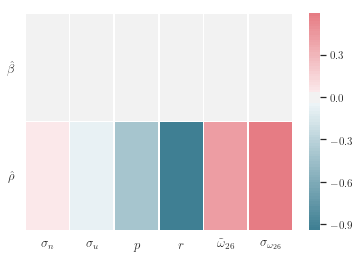

In [12]:
# tables abd heatmap
fs = 13
sns.set(rc={'text.usetex' : True})
cmap = sns.diverging_palette(220, 10, sep=10, n=100)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax = sns.heatmap(brute_est,annot=False,fmt="2.2f",annot_kws={"size": fs},xticklabels=fixed_par_tex,yticklabels=est_par_tex,center=0,linewidth=.5,cmap=cmap)

plt.yticks(rotation=0) 
ax.tick_params(axis='both', which='major', labelsize=fs)
plt.savefig('output\sense_est_brute.pdf',bbox_inches="tight")


num_theta = len(est_par)
num_gamma = len(fixed_par)
name = 'output\gp2002_all_brute' + add_str 
with open(name + '.tex',"w") as file:
    file.write("\\begin{tabular}{l*{%d}{c}} \\toprule \n" %(2*num_theta))
    file.write("& \\multicolumn{%d}{c}{Sensitivity} " %(num_theta))
    file.write("& \\multicolumn{%d}{c}{Re-estimation} \\\\ \\cmidrule(lr){2-3} \\cmidrule(lr){4-5}  \n" %(num_theta))
    for i in range(2):
        for p in range(num_theta):
            file.write("& %s " %est_par_tex[p])
    file.write("\\\\ \\cmidrule(lr){2-%d} \n " %(2*num_theta+1))

    
    for g in range(num_gamma):
        file.write(" %s " %fixed_par_tex[g])
        # sensitivity
        for t in range(num_theta):
            file.write("& %2.3f " %smd_base.sens2e[t,g])
        # brute-force
        for t in range(num_theta):
            file.write("& %2.3f " %brute_est[t,g])
        file.write("\\\\ \n ")

    file.write("\\bottomrule \n \\end{tabular}" )
    
    
name = 'output\gp2002_all_brute_H' + add_str 
with open(name + '.tex',"w") as file:
    file.write("\\begin{tabular}{l*{%d}{c}} \\toprule \n" %(2*num_theta))
    file.write("& \\multicolumn{%d}{c}{Sensitivity} " %(num_theta))
    file.write("& \\multicolumn{%d}{c}{Re-estimation} \\\\ \\cmidrule(lr){2-3} \\cmidrule(lr){4-5} \n" %(num_theta))
    for i in range(2):
        file.write("& $H^e_{30}$ & $H^e_{60}$ ")
    file.write("\\\\ \\cmidrule(lr){2-%d} \n " %(2*num_theta+1))

    
    for g in range(num_gamma):
        file.write(" %s " %fixed_par_tex[g])
        # sensitivity
        #file.write("& %2.3f ",ela_H30[g])
        #file.write("& %2.3f ",ela_H60[g])
        file.write(f"& {ela_H30[g]:2.3f} & {ela_H60[g]:2.3f} ")
        # brute-force
        for t in range(2):
            file.write("& %2.3f " %brute_H[t,g])
        file.write("\\\\ \n ")

    file.write("\\bottomrule \n \\end{tabular}" )

## Brute-force re-estimation of the model for various risk-free interest rates
This takes some time!

In [13]:
est_rho = np.empty(len(pct_grid))
est_beta = np.empty(len(pct_grid)) 
est_H30 = np.empty(len(pct_grid)) 
est_H60 = np.empty(len(pct_grid))
for i,pct in enumerate(pct_grid):
    model = gp.GP2002()
    model.par.r = model.par.r*(1.0 + pct/100)
    model.draw_random()

    smd = SMD.SimulatedMinimumDistance(model,mom_data,mom_fun,print_iter=False,options={'disp':True})
    smd.est_par = est_par
    
    if pct<0.01:
        smd.est = theta_base
    else:
        smd.estimate(theta0,weight)
    theta = smd.est

    # update model parameters
    for p in range(len(est_par)):
        setattr(model.par,est_par[p],theta[p]) 
        
    est_rho[i] = model.par.rho
    est_beta[i] = model.par.beta

    # calculate savings motives for re-estimated values
    upd_par = ("beta","rho","r")
    upd_val = np.empty(len(upd_par))
    for p in range(len(upd_par)):
        upd_val[p] = getattr(model.par,upd_par[p])
       
    (S,S_lc,S_b,W,W_lc,W_b,H) = gp.saving_decomposition(upd_val,upd_par)
    est_H30[i] = H[30-27]
    est_H60[i] = H[60-27]


beta 0.9441431553959989 rho 1.8603751373128499 r 0.0344 
Optimization terminated successfully.
         Current function value: 0.530279
         Iterations: 29
         Function evaluations: 59
beta 0.9440490718635401 rho 1.8427913310849249 r 0.034744 
Optimization terminated successfully.
         Current function value: 0.520491
         Iterations: 32
         Function evaluations: 63
beta 0.9439279804132601 rho 1.8273768834406339 r 0.035088 
Optimization terminated successfully.
         Current function value: 0.510901
         Iterations: 31
         Function evaluations: 60
beta 0.9438271222154835 rho 1.8102170754139186 r 0.035432 
Optimization terminated successfully.
         Current function value: 0.501510
         Iterations: 33
         Function evaluations: 64
beta 0.9436584394324647 rho 1.7982702056703506 r 0.035776 
Optimization terminated successfully.
         Current function value: 0.492314
         Iterations: 32
         Function evaluations: 62
beta 0.9435486528

In [14]:
dest_rho = est_rho[1:] - est_rho[0]
dest_beta = est_beta[1:] - est_beta[0] 
dest_H30 = est_H30[1:] - est_H30[0] 
dest_H60 = est_H60[1:] - est_H60[0]
dnoest_H30 = noest_H30[1:] - noest_H30[0] 
dnoest_H60 = noest_H60[1:] - noest_H60[0] 

dest_rho_e = 100*dest_rho/est_rho[0]
dest_beta_e = 100*dest_beta/est_beta[0]
dest_H30_e = 100*dest_H30/est_H30[0]
dest_H60_e = 100*dest_H60/est_H60[0]
dnoest_H30_e = 100*dnoest_H30/noest_H30[0]
dnoest_H60_e = 100*dnoest_H60/noest_H60[0]

g = 3 # interest rate parameter in gamma

num_theta = len(theta)
num_gamma = len(fixed_par_tex)
num_pct = len(dest_rho)

name = 'output\gp2002_sens_brute' +  add_str 
with open(name + '.tex',"w") as file:
    file.write("\\begin{tabular}{l*{%d}{c}} \\toprule \n" %num_pct)
    file.write("& \\multicolumn{%d}{c}{ Change in interest rate, $r$ } \\\\ " %(num_pct) )
    file.write("\\cmidrule(lr){2-%d}  \n" %(num_pct+1))
    for p in range(num_pct):
        file.write("& %s pct. " %pct_grid[p+1])

    # sensitivity
    file.write("\\\\ \\midrule \n")
    file.write("& \\multicolumn{%d}{c}{ \\emph{Sensitivity measure} } \\\\ "  %(num_pct))
    file.write("\\cmidrule(lr){2-%d}  " %(num_pct+1))
    for t in range(num_theta):
        file.write("\n %s " %est_par_tex[t])
        for p in range(num_pct):
            file.write("& %2.3f " %(np.array(pct_grid[p+1])*smd_base.sens2e[t,g]))
        file.write("\\\\")

    # brute force
    file.write("\\cmidrule(lr){2-%d}  \n" %(num_pct+1))
    file.write("& \\multicolumn{%d}{c}{ \\emph{Re-estimated $\\theta$ (brute force)} } \\\\ "  %(num_pct))
    file.write("\\cmidrule(lr){2-%d}  " %(num_pct+1))
    for t in range(num_theta):
        file.write("\n %s " %est_par_tex[t])
        for p in range(num_pct):
            if t==1:
                file.write(" & %2.3f " %dest_rho_e[p])
            else:
                file.write("& %2.3f " %dest_beta_e[p])            
        file.write("\\\\ ")
        
    file.write("\\bottomrule  \\end{tabular} \n")
    
    
# savings motive
name = 'output\gp2002_sens_brute_H' +  add_str 
with open(name + '.tex',"w") as file:
    file.write("\\begin{tabular}{l*{%d}{c}} \\toprule \n" %num_pct)
    file.write("& \\multicolumn{%d}{c}{ Change in interest rate, $r$ } \\\\ " %(num_pct) )
    file.write("\\cmidrule(lr){2-%d}  \n" %(num_pct+1))
    for p in range(num_pct):
        file.write("& %s pct. " %pct_grid[p+1])

    # sensitivity
    file.write("\\\\ \\midrule \n")
    file.write("& \\multicolumn{%d}{c}{ \\emph{Sensitivity measure} } \\\\ "  %(num_pct))
    file.write("\\cmidrule(lr){2-%d}  " %(num_pct+1))
    
    file.write("\n $H^e_{30}$ ")
    for p in range(num_pct):
        file.write(" & %2.3f " %(np.array(pct_grid[p+1])*ela_H30[g]))
    file.write("\n \\\\ $H^e_{60}$ ")
    for p in range(num_pct):
        file.write(" & %2.3f " %(np.array(pct_grid[p+1])*ela_H60[g]))
            

    # brute force
    file.write("\\\\ \\cmidrule(lr){2-%d}  \n" %(num_pct+1))
    file.write("& \\multicolumn{%d}{c}{ \\emph{Re-estimated $\\theta$ (brute force)} } \\\\ "  %(num_pct))
    file.write("\\cmidrule(lr){2-%d}" %(num_pct+1))
    
    file.write("\n $H^e_{30}$ ")
    for p in range(num_pct):
        file.write(" & %2.3f " %dest_H30_e[p])
    file.write("\\\\ \n $H^e_{60}$ ")
    for p in range(num_pct):
        file.write(" & %2.3f " %dest_H60_e[p])      
           
            
    # Current pracice
    file.write("\\\\ \\cmidrule(lr){2-%d}  \n" %(num_pct+1))
    file.write("& \\multicolumn{%d}{c}{ \\emph{Fixed $\\theta$ }} \\\\ "  %(num_pct))
    file.write("\\cmidrule(lr){2-%d}" %(num_pct+1))
    
    file.write("\n $B^e_{30}$ ")
    for p in range(num_pct):
        file.write(" & %2.3f " %dnoest_H30_e[p])
    file.write("\\\\ \n $B^e_{60}$ ")
    for p in range(num_pct):
        file.write(" & %2.3f " %dnoest_H60_e[p])  
        
    file.write("\\\\ \n ")
        
    file.write("\\bottomrule  \\end{tabular} \n")

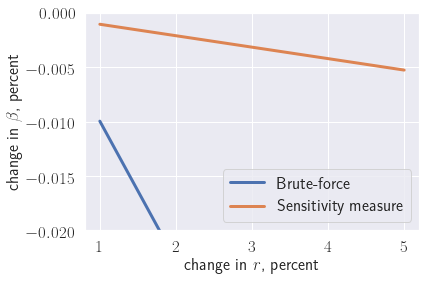

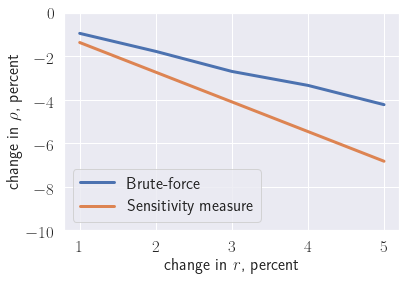

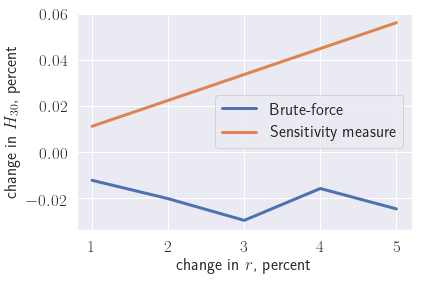

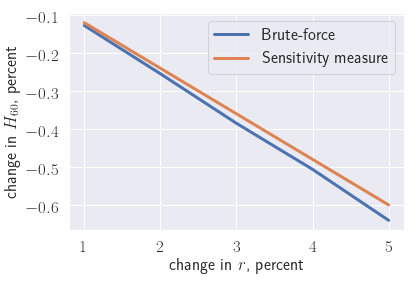

In [15]:
# figures

lw = 3
fs = 17

g = 3
t = 0 

# parameters
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(pct_grid[1:],dest_beta_e,linewidth=lw)
ax.plot(pct_grid[1:],np.array(pct_grid[1:])*smd_base.sens2e[t,g],linewidth=lw)

ax.set_ylim(-0.020,0)
# ax.set_ylim(0,1.4)

ax.set_xlabel(r'change in $r$, percent',fontsize=fs)
ax.set_ylabel(r'change in $\beta$, percent',fontsize=fs)

ax.legend(('Brute-force','Sensitivity measure'),fontsize=fs)
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=fs)

plt.savefig('output\sens_brute_beta' + add_str + '.pdf' ,bbox_inches="tight")

g = 3
t = 1 

# parameters
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(pct_grid[1:],dest_rho_e,linewidth=lw)
ax.plot(pct_grid[1:],np.array(pct_grid[1:])*smd_base.sens2e[t,g],linewidth=lw)

ax.set_ylim(-10,0)
# ax.set_ylim(0,1.4)

ax.set_xlabel(r'change in $r$, percent',fontsize=fs)
ax.set_ylabel(r'change in $\rho$, percent',fontsize=fs)

ax.legend(('Brute-force','Sensitivity measure'),fontsize=fs)
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=fs)

plt.savefig('output\sens_brute_rho' + add_str + '.pdf' ,bbox_inches="tight")

g = 3
t = 1 

# saving measure
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(pct_grid[1:],dest_H30_e,linewidth=lw)
ax.plot(pct_grid[1:],np.array(pct_grid[1:])*ela_H30[g],linewidth=lw)

#ax.set_ylim(-10,0)
# ax.set_ylim(0,1.4)

ax.set_xlabel(r'change in $r$, percent',fontsize=fs)
ax.set_ylabel(r'change in $H_{30}$, percent',fontsize=fs)

ax.legend(('Brute-force','Sensitivity measure'),fontsize=fs)
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=fs)

plt.savefig('output\sens_brute_H30' + add_str + '.pdf' ,bbox_inches="tight")


# saving measure
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(pct_grid[1:],dest_H60_e,linewidth=lw)
ax.plot(pct_grid[1:],np.array(pct_grid[1:])*ela_H60[g],linewidth=lw)

#ax.set_ylim(-10,0)
# ax.set_ylim(0,1.4)

ax.set_xlabel(r'change in $r$, percent',fontsize=fs)
ax.set_ylabel(r'change in $H_{60}$, percent',fontsize=fs)

ax.legend(('Brute-force','Sensitivity measure'),fontsize=fs)
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=fs)

plt.savefig('output\sens_brute_H60' + add_str + '.pdf' ,bbox_inches="tight")
